# Effective Schema Design

- Designing the schema effectively

# Table Partitioninig

- in the result cache?
- check shared SQL area

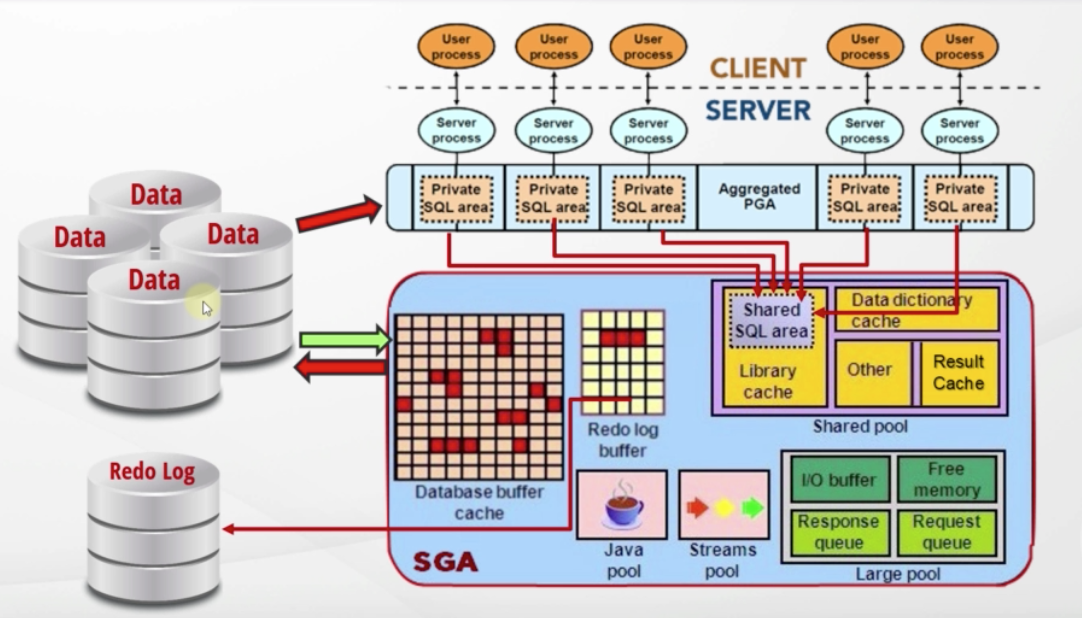

- If the data that we want is in the specific partition, then the server will not search all the data to get the target. It will read only from one partition. 

# How an SQL statement is processed?

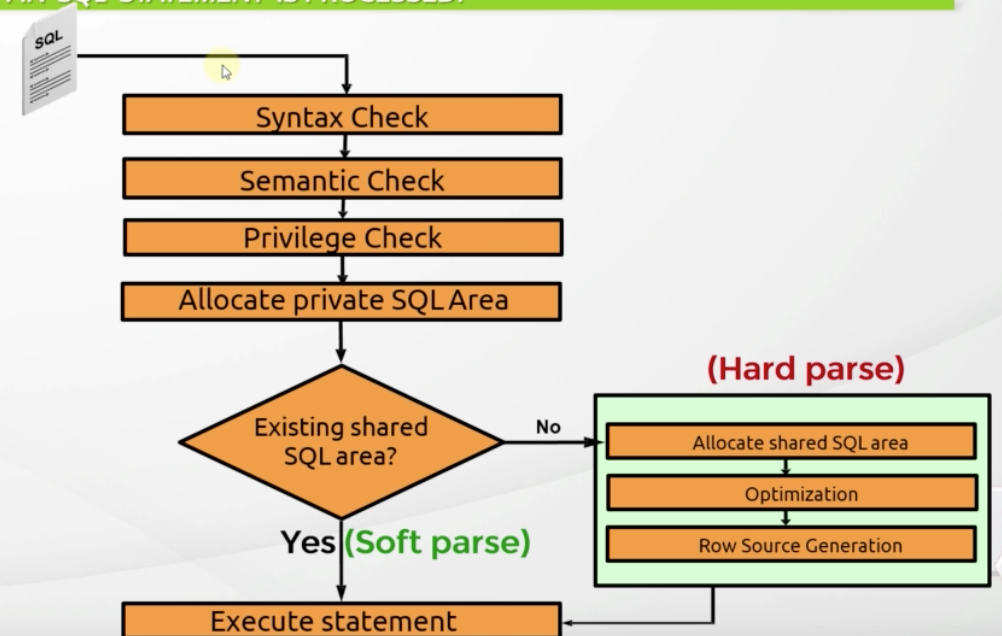

- Syntax check : is the SQL correct?
- semantic check
- privilege check
- allcate rpivate SQL area
- Existing shared SQL area?
- Soft parse or Hard parse

- Soft parse is enabled by the hashing of the query
so
'select first_name, last_name from employees' != 'select last_name, first_name from employess'

# Why do we need the optimizer?

- Chech schema information
- find possible access paths
    - use index, read whole table ...
- Check Statistics
    - Result is 1% of the whole table -> Use index
    - Result is 25% of the whole table -> Read whole table

# Optimizer overview

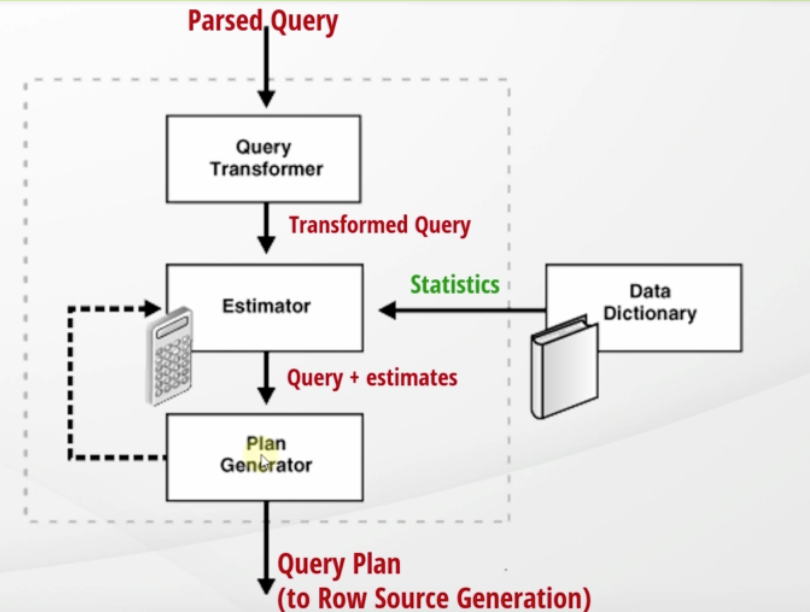

- Transformer : Change the query to a better one
- Estimator
    - A cost is the combination of the CPU usage, Memory usage and the Disc Usage of our query
- Plan Generator
    - Hand the query plan to Row Source Generation

# Query Transfomer

- Query transformer tranforms the quer into a better performing one but semantically equivalent of it
- If the transform isn't better, it uses the original one
- Time restriction and old statistics may lead a wrong plan creation
- OR Expansion
    - Using OR in the where clause will prevent index usages 

```sql
SELECT * FROM sales WHERE prod_id = 14 or promo_id = 33; --1,000,000 rows
```
to
```sql
SELECT * FROM sales WHERE prod_id = 14
UNION ALL
SELECT * fROM sales WHERE promo_id = 33 and prod_id <> 14;
```
    
    - Estimate 2 queries and return the better one by its cost

- Subquery unnecting
    - the optimizer transforms a nested query into a join statement

```sql
SELECT * FROM sales WHERE cust_id IN (
    SELECT cust_id FROM custormers
);
```
- this query first returns all the sales, and then compares them all by the list of customers retrieved by the subquery

so this is transformed by the transformer like
```sql
SELECT sales.*
FROM sales, customers
WHERE sales.cust_id = customers.cust_id;
```
- this query uses the index on the cust_id and do not render all the sales data at first.

- List of popular methods are
    - Complex view merging
    - in to exists
    - filter pushdowns
  

# Selectivity & Cardinality

- selectivity - relating to cost calculation, plan management
    - the estimate proportion of the rows that we return from our query based on the total rows of that table

- If the selectivity is close to zero but not zero that means all query is pretty selective : high selectivity

- Cardinality : total number of rows * selectivity

- Why selectivity and cardinality important?
    - selectivity affects the estimates in I/O cost
    - Selectivity affects the sort cost
    - Cardinality is used to determine join, and filter cost
    - incorrect selectivity and cardinality = incorrect plan cost estimation
    
    
- DB doesn't know the exact number of the rows returned, so it should 'estimate' it

if 
```sql
SELECT * FROM sales WHERE promo_id = 999;
```
- return 887,837 rows from 918,843 total
```sql
SELECT * FROM sales WHERE promo_id = 33;
```
- return 2,074 rows

```sql
    SELECT * FROM sales WHERE promo_id = 999;
```
- first it checks the distinct values of the column
```sql
SELECT num_distinct FROM dba_tab_columns
WHERE table_name = 'SALES';
``` 
- if the table rows is 1,000,000, it estimates 250,000 rows for the first query, so it think the query is not 'selective'
- But for the promo_id = 33 case, it is enough to be 'selective'
- so there's high possibility to select a bad execution plan

```sql
SELECT * FROM sales WHERE cust_id = 100001;
```
- 7059 distinct values - > selectivity = 1 / 7059
```sql
SELECT * FROM sales WHERE cust_id = 100001 AND promo_id = 999 AND channel_id = 9;
```
- selectivity = 1/4 * 1/7059 * 1/4

# What is 'cost' in detail?

- Cost is the optimizer's best estimate of the nubmer of I/Os to execute a statement

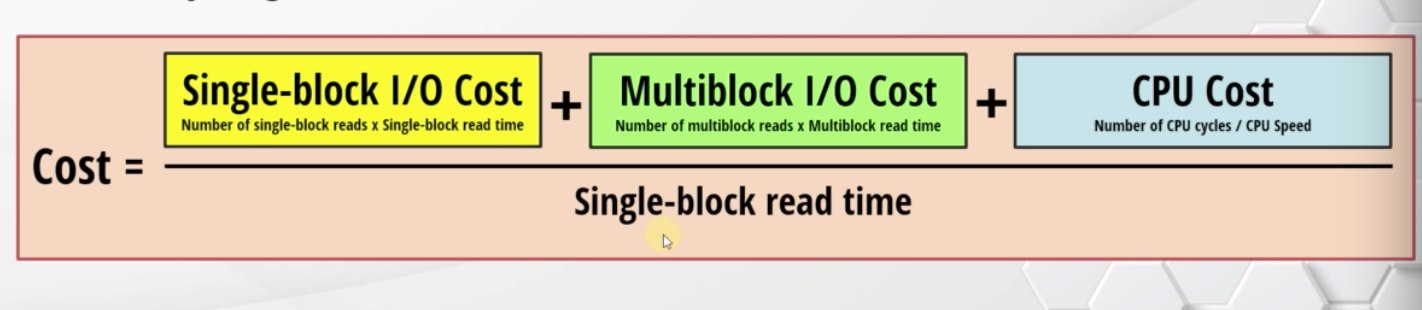

- read block by block 

# Plan Generator

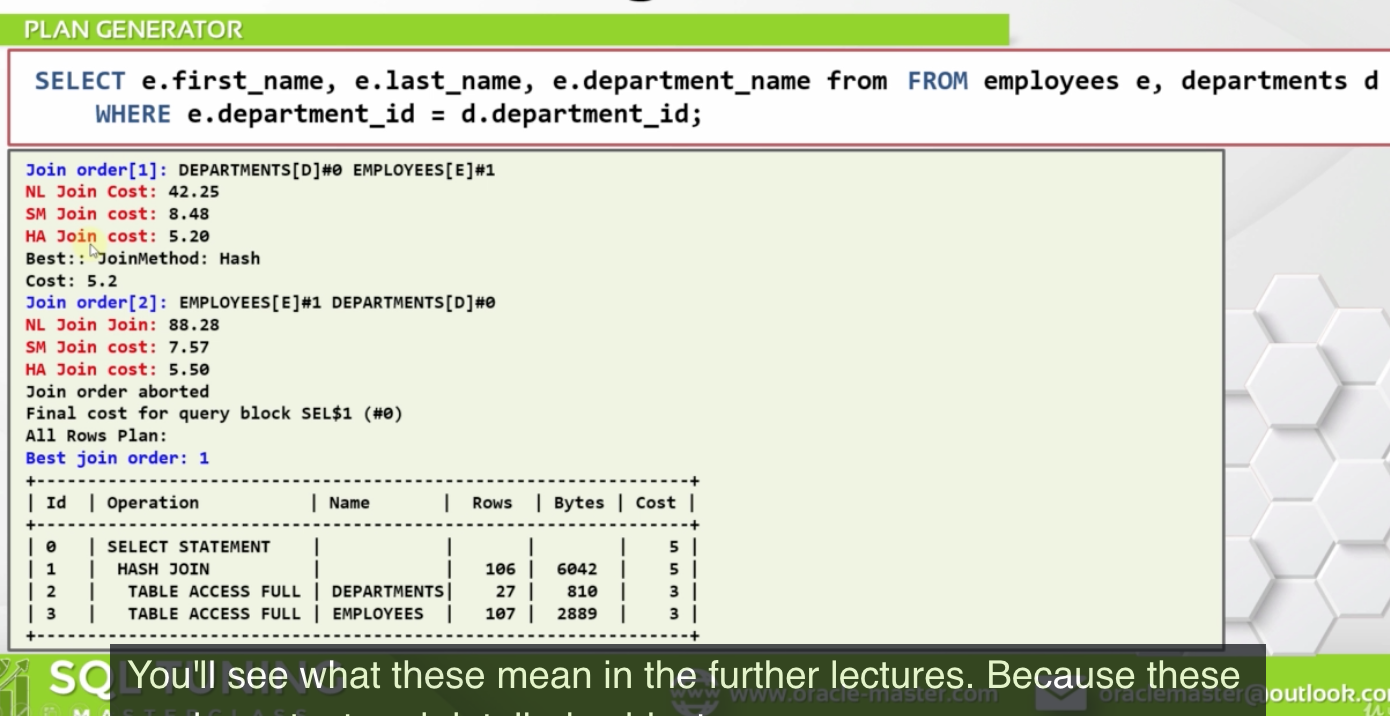

- on join syntax, there are a driving table and a joining table
    - driving table : table that is rendered first for join, normally choose the small one is the best
    
- And try nested join, sort merge join, and hash join

# Row source generator